In [11]:
import numpy as np
import pandas as pd
import itertools
import math
import scipy.special
import random
import copy

In [12]:
titanic_data = pd.read_csv("data/small.csv")
wine_data = pd.read_csv("data/medium.csv")

In [13]:
def get_variable_values(df):
    return {c: list(df[c].unique()) for c in df.columns}
    

The following functions are used to compute the score of a Bayesian Network:

    This function computes the different M_ijk values for (X_i,Parents(X_i)

In [14]:
#Returns a dict (X_i,instance(parents(x_i))) : count
def compute_all_combinations(var,parents,data):
    #var is a dict of size 1 with var as key and list of values it can take as value
    #Parents is a dict with parent names as keys and list of values they can take as values
    values = []
    variables = []
    for elem in var.keys():
        values.append(elem)
        variables.append(var[elem])
    for elem in parents.keys():
        values.append(elem)
        variables.append(parents[elem])
    variables = list(itertools.product(*variables))
    #Computing the M_ijk values and storing them
    #getting the variable and parents names
    var_name = list(var.keys())[0]
    parent_names = list(parents.keys())
    new_data = data[[var_name] + parent_names]
    new_data.head()
    #transforming the dataframe into a list of tuples
    new_data = list(new_data.itertuples(index=False, name=None))
    count_dict={}
    for var in variables:
        count_dict[var] = 0
    for row in new_data:
        count_dict[row] += 1
    return count_dict
            
            
        
        
    

    For a fixed instance of parent values, returns a dict with the different values X_i can take as keys and the count as values

In [15]:
def compute_fixed_parents(var,parent_values,count_dict):
    #Var is a dict with all of the potential values as a value
    #parent_values is a tuple of fixed parent values
    var_name = list(var.keys())[0]
    new_dict = {}
    for elem in var[var_name]:
        new_dict[elem] = 0
    for key in count_dict.keys():
        #Split the tuple to get the x_value and the parent instantiation
        instantiation = key[1:]
        if instantiation == parent_values:
            new_dict[key[0]] += count_dict[key]
    return new_dict
        
    

Computes this part of the score sum : 
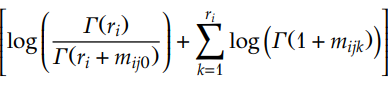

In [3]:

def first_sum(var,parent_values,count_dict):
    x_counts = compute_fixed_parents(var,parent_values,count_dict)
    m_ij_0 = sum(x_counts.values())
    internal_sum = 0
    for key in x_counts:
        internal_sum += scipy.special.loggamma(1 + x_counts[key])
    #Finding the value of r_i
    var_name = list(var.keys())[0]
    r_i = len(var[var_name])
    internal_sum += (scipy.special.loggamma(r_i) - scipy.special.loggamma(r_i + m_ij_0))
    
    return internal_sum
    
        

Computes the following part of the score sum : 
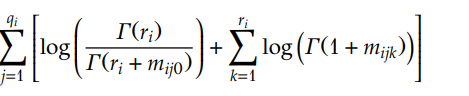

In [4]:
def sum_over_parents(var,parents,data):
    new_data_counts = compute_all_combinations(var,parents,data)
    parent_values = set()
    #Finding all the parents combinations
    for key in new_data_counts.keys():
        extracted_value = key[1:]
        parent_values.add(extracted_value)
    #Computing the outer-internal sum of the score
    ret_sum = 0
    for instantiation in parent_values:
        ret_sum += first_sum(var,instantiation,new_data_counts)
    return ret_sum
        

        
    

Summing over all variables

In [6]:
def compute_score(network,data,variable_values):
    score = 0
    for variable in variable_values.keys():
        #On a besoin d'un argument {variable_actuelle : valeurs}
        var_dict = {}
        var_dict[variable] = variable_values[variable]
        #Et d'un autre argument {parents de la variable : leur valeurs}
        parents_dict = {}
        for parent in network.parents[variable]:
            parents_dict[parent] = variable_values[parent]
        score += sum_over_parents(var_dict,parents_dict,data)
    return score
        
            
        

The Bayesian network class:
This is implemented as a digraph represented by its adjacency list (self.parents)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image, display
import tempfile

class BayesianNetwork:
    
    def __init__(self,variables = [],edges = []):
        self.variables = variables
        self.parents = {}
        self.edges = []
        #Creating a dictionary for storing dependency relationships between variables
        for node in variables:
            self.parents[node] = []
        self.add_edges(edges)
            
    #Adding a dependency
    def add_edge(self,edge):
        self.edges.append(edge)
        self.parents[edge[1]].append(edge[0])
    
    
    def add_edges(self,edges):
        for edge in edges:
            self.edges.append(edge)
            self.parents[edge[1]].append(edge[0])

    #Removing a dependency
    def remove_edge(self,edge):
        if edge[0] in self.parents[edge[1]]:
            self.parents[edge[1]].remove(edge[0])
            self.edges.remove(edge)
    

    #Creating a new Bayesian network

    def copy(self):
        return BayesianNetwork(self.variables,self.edges.copy())
    
    def show_network(self):
        nx_graph = nx.DiGraph()
        nx_graph.add_nodes_from(self.variables)
        nx_graph.add_edges_from(self.edges)
        #nx.draw(nx_graph,with_labels = True)
        with tempfile.TemporaryFile() as f:
            nx.nx_agraph.write_dot(nx_graph, f)
            f.seek(0)
            dot = f.read().decode()
        display(Image(pgv.AGraph(dot).draw(format='png', prog='dot')))
        
    
    def __eq__(self,graph):
        set_1 = set(self.edges)
        set_2 = set(graph.edges)
        return set_1 == set_2
        
            
        
    

Functions for getting a new network either by :
- Adding an edge
- Removing an edge
- Reversing an edge\
In order to prevent the creation of cycles or loops, a DFS is done in order to verify if a non-authorized digraph is created

In [16]:
def has_cycle(network,added_edge,reverse = False):
    graph = {}
    for elem in network.parents.keys():
        graph[elem] = []
        for elem_2 in network.parents[elem]:
            graph[elem].append(elem_2)
    if reverse: #If reversing the graph, we need to remove the edge from the adjacency list before adding
                #its reverse
        graph[added_edge[0]].remove(added_edge[1])
        graph[added_edge[1]].append(added_edge[0])
    else:
        #If we add an edge
        graph[added_edge[1]].append(added_edge[0])
    visited = set()
    stack = set()
    # DFS function
    def dfs(node):
        visited.add(node)
        stack.add(node)
        if node in graph:
            for parent in graph[node]:
                if parent not in visited:
                    if dfs(parent):
                        return True
                elif parent in stack:
                    return True
        stack.remove(node)
        return False
    # Check for cycles
    for node in graph:
        if node not in visited:
            if dfs(node):
                return True
    return False

def get_new_network(network):
        #Choosing from either deleting an edge or adding one
        i = random.randint(0,2)
        new_network = network.copy()
        #Adding an edge
        u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
        if i == 0 or (len(network.edges) == 0):
            simple_digraph = False
            while(True):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
                #Checking if it's a new edge
                if (network.variables[u] not in network.parents[network.variables[w]]):
                    #Checking if it's not a loop and that it does not create a cycle
                    if ((u != w) and not(has_cycle(network,(network.variables[u],network.variables[w])))):
                        new_network.add_edge((network.variables[u],network.variables[w]))
                        break
        #Deleting an edge
        elif i == 1:
            while(network.variables[u] not in network.parents[network.variables[w]]):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
            new_network.remove_edge((network.variables[u],network.variables[w]))
        #Reversing an edge
        else:
            visited = set()
            #Choosing a random edge to reverse
            while(True):
                if len(visited) == len(network.edges):
                    return network
                i = random.randint(0,len(network.edges)-1)
                var_1,var_2 = network.edges[i]
                if (var_1,var_2) in visited:
                    continue
                visited.add((var_1,var_2))
                #Checking if reversing an edge does not create a cycle
                if not(has_cycle(network,(var_2,var_1),reverse = True)):
                    new_network.remove_edge(network.edges[i])
                    new_network.add_edge((var_2,var_1))
                    break
        return new_network
            
                

Implementation of the simulated annealing algorithm

In [17]:
def acceptance_probability(old_score, new_score, temperature):
    if new_score > old_score:
        return 1.0
    else:
        return np.exp((new_score - old_score) / temperature)


def bn_simulated_annealing(data,init_network,temperature = 1000,cooling_rate = 0.95,max_iterations = 1000):
    variable_values = get_variable_values(data)
    current_network = init_network.copy()
    current_score = compute_score(current_network,data,variable_values)
    print("initial score",current_score)
    visited_graphs = set()
    for i in range(max_iterations):
        if (i % 10 == 0):
            #print("iteration",i)
            pass
        new_network = get_new_network(current_network)
        new_score = compute_score(new_network,data,variable_values)
        
        prob = acceptance_probability(current_score, new_score, temperature)
        rand = np.random.rand()
        if  rand < prob:
            current_network = new_network
            current_score = new_score
            #print(current_score)
        temperature *= cooling_rate
    print("optimal network score",current_score)
    return current_network
    

Function that finds the optimal Bayesian network given data

In [18]:

def get_network(data):
    variable_values = get_variable_values(data)
    initial_network = BayesianNetwork(variables = list(variable_values.keys()))
    optimal_network = bn_simulated_annealing(data,initial_network)
    return optimal_network
optimal_titanic_network = get_network(titanic_data)
optimal_wine_network = get_network(wine_data)

initial score -4166.225858784904
optimal network score -3794.8555977097967
initial score -45367.62511363244
optimal network score -41923.20457489983


Obtaining networks from bnlearn library for comparison

[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


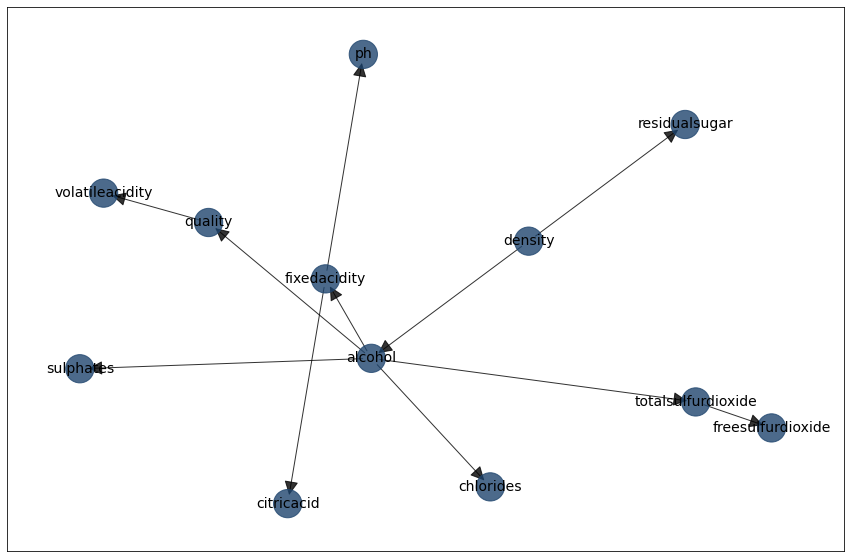

In [19]:
import bnlearn as bn

# Structure learning
DAG = bn.structure_learning.fit(wine_data)

# Plot
G = bn.plot(DAG)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


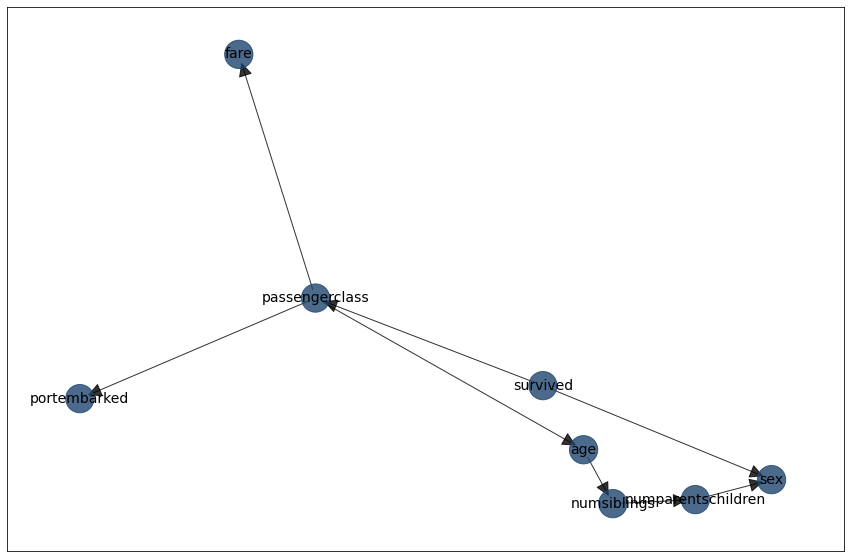

In [20]:
# Structure learning
DAG = bn.structure_learning.fit(titanic_data)

# Plot
G = bn.plot(DAG)

Our found networks : 

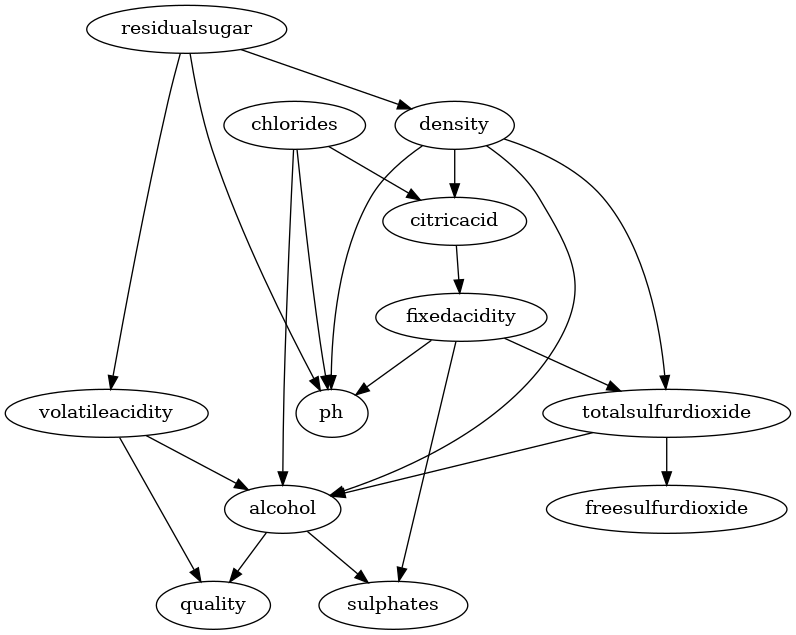

In [21]:
optimal_wine_network.show_network()

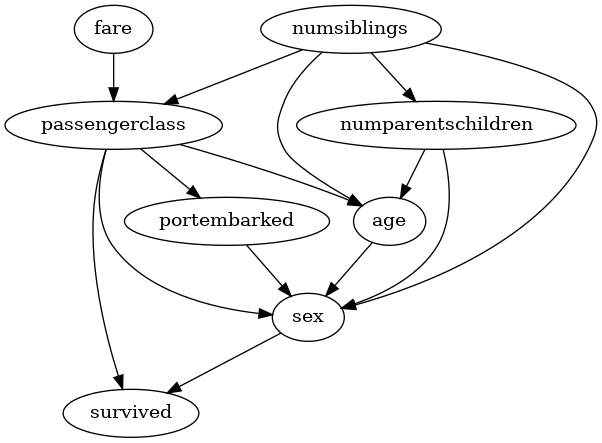

In [22]:
optimal_titanic_network.show_network()

Parameter estimation using a frequentist approach from the data (TPCs)

In [23]:
class TPC:
    
    def __init__(self,network,data):
        self.network = network
        self.data = data
        self.table = {}
        variable_values = get_variable_values(data)
        # create a dictionary as key : node and value : dictionary of TPC
        for node in variable_values.keys():
            node_dict = {}
            node_dict[node] = variable_values[node]
            parents_dict = {}
            for parent in network.parents[node]:
                parents_dict[parent] = variable_values[parent]
            dico = compute_all_combinations(node_dict,parents_dict,data) 
            parent_values = set()
            #Finding all the parents combinations
            for key in dico.keys():
                extracted_value = key[1:]
                parent_values.add(extracted_value)
            parent_dict={}
            # parent_dict : dictionary with key : tuple of parent and value : number of presence
            for parent in parent_values :
                count_dict = compute_fixed_parents(node_dict,parent,dico)
                total = 0
                for key in count_dict.keys():
                    total += count_dict[key]
                parent_dict[parent]=total #dico avec clé le tuple de valeur de parent et valeur le nombre de fois ou ca apparait
            dico_proba={}
            #dictionary with key : tuple of variable and its parents and value : proba 
            for last_key in dico.keys():
                total = parent_dict[last_key[1:]]
                if total == 0 :
                    proba = 0
                else:
                    proba = dico[last_key]/total
                dico_proba[last_key]=proba
            self.table[node]= dico_proba
    
    
    def show_table(self,variable):
        first_line = ""
        first_line += variable
        first_line += " "
        for elem in self.network.parents[variable]:
            first_line += (elem + ' ')
        print(first_line)
        for key in self.table[variable].keys():
            print(key,self.table[variable][key])

Class for target inference given data using the Markov blanket of the target variable

In [24]:
class Proba:

    def __init__(self,variable, donnee, tpc, data, network):
        self.variable = variable
        self.donnee = donnee
        self.network = network
        self.parent = self.network.parents[variable] #[sex, age, ..]
        self.data = data
        self.tpc= tpc
        self.prob_parent={}
        variable_values = get_variable_values(data)
        # Make a dictionary with as a key : tuple of variable and its parents, as value : value of proba
        for i in variable_values[variable]:
            x= []
            # Finding tuple of parents's value of variable
            for p in self.parent:
                x += [self.donnee[p]] 
            tupple = tuple([i]+x) 
            self.prob_parent[i] = self.tpc.table[variable][tupple] 

        #Finding children of the variable
        self.children = []
        for key in self.network.parents.keys():
            if variable in self.network.parents[key]:
                self.children.append(key)

        # Calculate P(variable| parent) thanks to the Couverture de Markov
        for i in variable_values[variable]:
            for enfant in self.children :
                x= []
                for p in self.network.parents[enfant]:
                    if p not in self.donnee.keys():
                        x+= [i]
                    else :
                        x += [self.donnee[p]]
                tupple = tuple([self.donnee[enfant]]+x) 
                self.prob_parent[i] *= self.tpc.table[enfant][tupple]
        total=0
        index = 0
        normaliser = 0
        # To find the proba maximal and the value of variable
        for i in self.prob_parent.keys():
                normaliser += self.prob_parent[i]
                if self.prob_parent[i]>total:
                    total = self.prob_parent[i]
                    index = i
        self.max = index 
        self.value_max = total/normaliser





Creating a Naïve Bayesian network with edges only from target to other variables

In [25]:
#Implémentation du Naïve Bayes

def naive_bayes(target_name,data): #Returns a Bayesian network after specifying the target
    variables = list(get_variable_values(data).keys())
    edges = []
    for variable in variables:
        if variable != target_name:
            edges.append((target_name,variable))
    network = BayesianNetwork(variables,edges)
    return network,TPC(network,data)


In [26]:
def predict(network,row,tpc,data,target_name):
    p = Proba(target_name, row, tpc, data, network)
    return p.max

Creating new networks from a train set in order to compare their performance from a validation set

In [27]:
from sklearn.model_selection import train_test_split

def split_and_compare(data,test_size,target_name):
    #Splitting the data
    train,test = train_test_split(data, test_size=test_size)
    #Finding the Bayesian network from the train data using simulated annealing
    variable_values = get_variable_values(data)
    network = BayesianNetwork(variables = list(variable_values.keys()))
    optimal_network = bn_simulated_annealing(train,network)
    opt_tpc = TPC(optimal_network,train)
    #Creating the Bayesian network and its TPC from the train partition
    naive_net,naive_tpc = naive_bayes(target_name,train)
    #Computing accuracies for the two different models
    #Transforming the test df to a list of dictionaries to get the Proba prediction
    test_dict = train.to_dict('records')
    opt_accuracy = 0
    naive_accuracy = 0
    total = len(test_dict)
    for row in test_dict:
        true_value = row.pop(target_name)
        opt_prediction = predict(optimal_network,row,opt_tpc,data,target_name) 
        if opt_prediction == true_value:
            opt_accuracy += 1
        naive_prediction = predict(naive_net,row,naive_tpc,data,target_name)
        if naive_prediction == true_value:
            naive_accuracy += 1
    print("Bayesian network accuracy",opt_accuracy / total)
    print("Naive assumption accuracy",naive_accuracy / total)
    return optimal_network
    
    
    

In [28]:
net_titanic = split_and_compare(data,0.3,'survived')

NameError: name 'data' is not defined

In [ ]:
net_wine = split_and_compare(data_wine,0.3,'quality')

Class computing P(variables | other_variables)

In [ ]:
class Proba_bis:
    def __init__(self,variables,conditionals,data):
        self.variables = variables
        self.conditionals = conditionals
        data_variables = get_variable_values(data)
        #truncating the interesting columns of the dataframe
        new_data = data[variables + conditionals]
        values = []
        for elem in variables:
            values.append(data_variables[elem])
        for elem in conditionals:
            values.append(data_variables[elem])
        #counting the occurences of the different combinations
        values = list(itertools.product(*values))
        new_data = list(new_data.itertuples(index=False, name=None))
        self.count_dict={}
        for var in values:
            self.count_dict[var] = 0
        for row in new_data:
            self.count_dict[row] += 1
        #Finding the number of fixed values for parent variables
        parent_values = []
        for elem in conditionals:
            parent_values.append(data_variables[elem])
        parent_values = list(itertools.product(*parent_values))
        parent_count = {}
        parent_data = data[conditionals]
        parent_data = list(parent_data.itertuples(index=False, name=None))
        parent_dict = {}
        for val in parent_values:
            parent_count[val] = 0
        for row in parent_data:
            parent_count[row] += 1
        #Dividing the count in self.count_dict by total parent values to compute conditionals
        cut = len(conditionals)
        for elem in self.count_dict.keys():
            parent = elem[-cut:]
            self.count_dict[elem] = self.count_dict[elem] / parent_count[parent]
        
    def show(self):
        print(self.variables + self.conditionals)
        print(self.count_dict)
        
        

Transforms a dictionary to a dataframe (useful for the conditional dependency experiment for table reprsentation)

In [ ]:
def dict_to_table(dico,col_1,col_3):
    df = pd.DataFrame.from_dict(dico, orient='index', columns=[col_3])

    # Reset the index to create separate columns for X and Y
    df.reset_index(inplace=True)
    df.rename(columns={'index': col_1}, inplace=True)

    return df

Computes the percentage difference between P(joint_variables | conditionals) and product(P(variable in joint_variables|conditonals))

In [ ]:
def get_table(joint_variables,conditionals,data):
    p_1 = Proba_bis([joint_variables[0]],conditionals,data).count_dict
    p_2 = Proba_bis([joint_variables[1]],conditionals,data).count_dict
    prod_dict = {}
    for f in p_1.keys():
        for p in p_2.keys():
            if f[1] == p[1]:
                key = (f[0],p[0],p[1])
                prod_dict[key] = p_1[f] * p_2[p]
    difference_dict = {}
    p = Proba_bis(joint_variables,conditionals,data)
    for tup in prod_dict.keys():
        if p.count_dict[tup] >= 0.05 and prod_dict[tup] >= 0.05:
            diff = (p.count_dict[tup] - prod_dict[tup]) / p.count_dict[tup]
            diff *= 100
            difference_dict[tup] = abs(diff)
    title_str = "("
    for elem in variables:
        title_str += (elem + ',')
    for elem in conditionals:
        title_str += (elem)
    title_str += ')'
    diff_table = dict_to_table(difference_dict,title_str,'Difference in %')
    
    return diff_table
    

In [ ]:
variables = ['density','quality']
conditionals = ['alcohol']

get_table(variables,conditionals,wine_data)